In [214]:
#import all neccessary libraries
import networkx as nx
import random
import copy
import numpy as np
import scipy.stats as st

In [275]:


def create_farm_network(n, pe, dist, waste_mean, waste_std, number_of_wastesites):
    '''
    This function creates the network for the model. It has several parameters that we can use to change the setup:
    n is the number of nodes
    pe is the probability that any two nodes are connected 
    dist is the maximum distance between nodes
    waste_mean is the maximum mean waste
    waste_std is the precentage of the mean waste that is the standard deviation 
    number_of_wastesites is the number of waste sites of the system
    
    The function returns the station, a list of the waste sites and the network
    '''
    
    #create random network
    farmnet = nx.fast_gnp_random_graph(n, pe)
    #create edge weights
    for i in farmnet.edges:
        farmnet.edges[i]['dist'] = np.random.uniform(dist)
    #create waste at nodes set to 0 initially
    nx.set_node_attributes(farmnet, values = 0, name = 'waste')
    
    #add waste mean std and type to all nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['wastemean'] = np.random.uniform(waste_mean)
        farmnet.nodes[i]['wastestd'] = farmnet.nodes[i]['wastemean'] * waste_std
        farmnet.nodes[i]['type'] = 'farm'
    #select statoin and adjust parameters
    station = random.choice(list(farmnet.nodes))
    farmnet.nodes[station]['wastemean'] = 0
    farmnet.nodes[station]['wastestd'] = 0
    farmnet.nodes[station]['type'] = 'station'
    
    #select wastesites and store them in list
    wastesites = []
    while len(wastesites) < number_of_wastesites:
        new = random.choice(list(farmnet.nodes))
        if new != station and new not in wastesites:
            wastesites.append(new)
    
    #change waste site parameters
    for i in wastesites:
        farmnet.nodes[i]['wastemean'] = 0
        farmnet.nodes[i]['wastestd'] = 0
        farmnet.nodes[i]['type'] = 'wastesite'
        
    #return network station and waste site list
    return farmnet, station, wastesites
    
    
    
def farmnet_update(farmnet):
    '''
    This function takes the farm netowork as input and adds waste to all nodes
    '''
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] += np.random.normal(farmnet.nodes[i]['wastemean'], farmnet.nodes[i]['wastestd'])
    
    
class truck:
    '''
    This class representsa truck and has sevel attributes and methods that influcne the network
    '''
    
    def __init__(self, position, storage_max,  fuel_max, speed, number, move = -np.inf, ftype = 0):
        
        self.storage = 0  #waste in truck
        self.storage_max = storage_max #max waste of truck
        self.position = position #current position of truck
        self.dist = 0  #distance to next node
        self.fuel = fuel_max  #current fuel in truck
        self.fuel_max = fuel_max #max fuel capacity of truck
        self.speed = speed #speed of the truck
        self.path = [] #next nodes the truck will visit
        self.number = number #id number of truck
        self.move = move #decides the performance of staying at the same node for the local path strategy
        self.ftype = ftype #decides the stratgy used for this truck
        
        
    def find_next_random_positions(self,farmnet, depth, station,wastesites, trucklist = [], optimize = True):
        '''
        This strategy find the next position using the random strategy.
        '''
        
        #assess possible next positions
        poss_next = [i for i in farmnet.neighbors(self.position)]
        
        #search while no next node is found
        while len(self.path) == 0:
            #choose random node
            n = random.choice(poss_next)
            #check if fuel allows to visit node and set up path to the node if it does
            if self.check_needs(farmnet, station, n, [0], self.position):
                self.path = [n]
                self.dist = nx.path_weight(farmnet, [self.position, n],'dist')
        
    
    def find_next_positions2(self,farmnet, depth, station,wastesites, trucklist = [], optimize = True):
        '''
        This strategy find the next position using the best node strategy. 
        '''
        
        #create list that stores all nodes other trucks plan to visit that are not wast sites or the station
        otherpaths = []
        for i in trucklist:
            if i != self.position and i != station and i not in wastesites:
                otherpaths += i.path
        
        #this variable stores the best node found so far and is initialized using the current node
        max_result = [-np.inf, self.position, 0]
        
        #look through all nodes in the graph to find best node
        for i in farmnet.nodes:
            
            #calcualte path to node and waste at node to get performance heuristic called new
            newd = nx.path_weight(farmnet,nx.shortest_path(farmnet, self.position ,i , 'dist'), 'dist')
            new = farmnet.nodes[i]['waste'] - newd
            
            #asses if enough fuel is in tank to visit node 
            if newd + nx.path_weight(farmnet,nx.shortest_path(farmnet, i, station, 'dist'), 'dist') < self.fuel:
                
                #add penalty if other truck plans to visit node
                if i in otherpaths:
                    #assess if node is a new max and update variable if it is
                    if new - 1000 > max_result[0]:
                        max_result = [new, i, newd]
                else:
                    #assess if node is a new max and update variable if it is
                    if new > max_result[0]:
                        max_result = [new, i, newd]
        
        #update path and distance with best node found
        self.path = [max_result[1]]
        self.dist = max_result[2]
                    
        
            
        
    def find_next_positions(self,farmnet, depth, station,wastesites, trucklist = [], optimize = True):
        '''
        This strategy find the next position using the local path strategy. The depth defines the depth of the strategy. 
        '''
        
        #create list that stores all nodes other trucks plan to visit that are not wast sites or the station
        otherpaths = []
        for i in trucklist:
            if i != self.position and i != station and i not in wastesites:
                otherpaths += i.path

        #create node stack to check for new best
        nodes = []
        #store best path found so far
        max_result = [self.position , self.move, []]
        #add current node to stack
        nodes.append([self.position, self.move, []])
        
        #count how many nodes at depth 1 we found and create list for the first one 
        found = 0
        foundn = []
        
        #search as long as we have nodes in stack
        while len(nodes) > 0:
            #define current node and delete it from stack
            current = nodes[-1]
            nodes.remove(current)
            
            #loop through neighboors of current node
            for i in farmnet.neighbors(current[0]):
                #test if neighbour is not too deep, can be visit with the fuel remaining, and is not the current node
                if len(current[-1]) < depth and self.check_needs(farmnet, station, i, current[-1], current[0]) and i not in current[-1]:
                    
                    #update found if we are at depth 1
                    if current[0] == self.position:
                        #store first node found at this depth
                        found += 1
                        if found == 1:
                            foundn = i
                    
                    #check if no other truck is planning to visit this node
                    if i not in otherpaths:
                    
                        dist_fill_add = 0
                        
                        #if we want to optimize we add a penalty/reward accroding to the change in distance to the closest waste site we the truck will be filled at the node
                        if optimize:
                            added = sum([farmnet.nodes[u]['waste'] for u in current[-1]]) + farmnet.nodes[current[0]]['waste'] + farmnet.nodes[i]['waste']
                            if added >= self.storage_max - self.storage:
                                dist_fill_add = min([nx.path_weight(farmnet,nx.shortest_path(farmnet, current[0] ,u , 'dist'), 'dist') for u in wastesites]) - min([nx.path_weight(farmnet,nx.shortest_path(farmnet, i ,u , 'dist'), 'dist') for u in wastesites])
                        
                        #add node to stack
                        if i != station:
                            if current[0] == self.position:
                                nodes.append([i, farmnet.nodes[i]['waste'] - farmnet.get_edge_data(current[0], i)['dist'] + dist_fill_add, current[-1] + [current[0]]   ])
                            else:
                                nodes.append([i,current[1] +  farmnet.nodes[i]['waste'] - farmnet.get_edge_data(current[0], i)['dist'] + dist_fill_add, current[-1] + [current[0]]   ])
                        else:
                            nodes.append([i, 10, current[-1] + [current[0]]   ])
            #update max if current is new max
            if current[1] > max_result[1]:
                max_result = current
        
        #if we are not getting fuel update the path to the best found path and the distance accordingly
        if found != 1:
            try:
                self.path = max_result[-1][1:]
            except:
                self.path = max_result[-1]


            self.path.append(max_result[0])
            if self.position != self.path[0]:
                self.dist = farmnet.get_edge_data(self.position, self.path[0])['dist']
            else:
                self.dist = 0
        #if we only found one node at depth 1 we are most likely getting fuel and should visit this node  
        else:
            
            self.path = [foundn]
            self.dist = farmnet.get_edge_data(self.position, self.path[0])['dist']
        

        
    
    def check_needs(self,farmnet, station, cp, pt, c0):
        '''
        This functin checks if we are able to visit a node and drive back to the station with the fuel remaining in the truck.
        '''
        
        #calualte shortest path from end node to station
        p = nx.shortest_path(farmnet, cp ,station , 'dist')
        #calculate weight of shorest path
        d1 = nx.path_weight(farmnet,p, 'dist')
        
        #calculate path from current node to end node 
        if c0 != self.position:
            d2 = nx.path_weight(farmnet,[self.position] + pt[1:]+ [c0] + [cp], 'dist')
        else:
            d2 = nx.path_weight(farmnet,[self.position] + pt[1:] + [cp], 'dist')
        
        #calcualte overall path
        d = d1 + d2
        
        #compare path to fuel left and return true if it is possbile to visite node
        if d < self.fuel:
            return True
        #otherwise return false
        else:
            return False
        
        
        
    def arrive(self,farmnet, wastesites,station, ftrack, wtrack):
        '''
        This function organizes the arrival of the truck at a node and does the appropriate actions. 
        '''
        #udate position and path
        self.position = self.path[0]
        self.path.remove(self.position)
        
        #do this if we arrive at a station
        if farmnet.nodes[self.position]['type'] == 'station':
            
            #add fuel and update fuel tracker
            ftrack += self.fuel_max - self.fuel
            self.fuel += self.fuel_max - self.fuel

            
        #do this if we arrive at a waste site
        elif farmnet.nodes[self.position]['type'] == 'wastesite':
            
            #update storage and waste tracker
            wtrack += self.storage
            self.storage = 0
            
        #do this if we arrive at a farm 
        else:
            #if we have enough storge left update waste at farm and storage 
            if self.storage_max - self.storage >= farmnet.nodes[self.position]['waste']:
                self.storage += farmnet.nodes[self.position]['waste']
                farmnet.nodes[self.position]['waste'] = 0
                
            #if we do not have enough storage left to colect all waste do this
            else:
                #fill truck up
                farmnet.nodes[self.position]['waste'] -= self.storage_max - self.storage
                self.storage = self.storage_max
                
                
                #find path to closes waste site
                closest = wastesites[0]
                newpath = nx.shortest_path(farmnet, self.position, closest , 'dist')

                for i in range(1,len(wastesites)):
                    op = nx.shortest_path(farmnet, self.position,wastesites[i] , 'dist')
                    if nx.path_weight(farmnet,op, 'dist') < nx.path_weight(farmnet, newpath, 'dist'):
                        newpath = op
                        closest = wastesites[i]
                
                #if we have enough fuel to drive to waste site and back to the statin so this
                if nx.path_weight(farmnet,nx.shortest_path(farmnet, self.position ,newpath[-1] , 'dist'), 'dist') + nx.path_weight(farmnet,nx.shortest_path(farmnet ,newpath[-1],station , 'dist'), 'dist') < self.fuel:
                    self.path = newpath[1:] 
                #otherwise drive to station
                else:
                    self.path = nx.shortest_path(farmnet, self.position ,station , 'dist')[1:]
        
        #update path
        if len(self.path) != 0:
            self.dist = nx.path_weight(farmnet,[self.position]+[self.path[0]] , 'dist')
            
        #return waste and fuel tracker
        return ftrack, wtrack
        
  
        
    def drive(self):
        '''
        This function handels the driving of the truck
        '''
        
        #update dist and fuel according to speed 
        if self.dist >= self.speed:
            self.dist -= self.speed
            self.fuel -= self.speed
            
        else:
            self.fuel -= self.dist
            self.dist = 0
            
    
        
        
    def findfunc(self, farmnet, depth, station,wastesites, trucklist = truck_list, optimize = True):
        '''
        This function selects a strategy based on the ftype defined for the truck
        '''
        
        #use best local path strategy
        if  self.ftype ==0:
            self.find_next_positions(farmnet, depth, station,wastesites, trucklist = truck_list, optimize = True)
        #use best node strategy
        elif  self.ftype ==1:
            self.find_next_positions2(farmnet, depth, station,wastesites, trucklist = truck_list, optimize = True)
        #use random strategy
        else:
            self.find_next_random_positions(farmnet, depth, station,wastesites, trucklist = truck_list, optimize = True)
        
    
    
    
def simulation(farmnet, truck_list, endtime, depth, station, wastesites, optimize = True):
    '''
    This function runs the simulatin for the defined paramters
    Inputs:
    farmnet: the network representing the farms and streets
    truck_list: list of truks
    endtime: how many hours to simulate
    depth: depth of local path strategy if choosen
    station: positin of station
    waste sites: list of all waste sites in network
    optimize: if local path strategy should use optimization
    '''
    
    #set time 
    time = 0
    
    #set trackers
    ftrack = 0
    wtrack = 0
    
    #find path for all trucks
    for i in truck_list:
        ftrack += i.fuel
        if len(i.path) == 0:
            i.findfunc(farmnet, depth, station,wastesites, trucklist = truck_list, optimize = optimize)
    
    
    #create waste at farms
    farmnet_update(farmnet)

    #run simulation for time specified
    while time < endtime:
        
        #update time
        time += 1
        
        #look thorugh all trucks
        for i in truck_list:
            
            #if no path is deinfed search for path according to strategy choosen for the truck
            if len(i.path) == 0:
                i.findfunc(farmnet, depth, station,wastesites, trucklist = truck_list, optimize = True)
            
            #if we arrive at a node call arriver function and update trackers
            if i.dist <= 0:
                
                ftrack, wtrack = i.arrive(farmnet, wastesites, station, ftrack, wtrack)
            #otherwise continue driving 
            else:
                i.drive()
                
        #if a day has passed we create new trash
        if time %24 == 0:
            farmnet_update(farmnet)
    
    #return trakers
    return ftrack, wtrack
            


(23959.25199399549, 647213.0854516865)


In [ ]:
#define lists to store results
f1op11opt = []
f1op11nopt = []

#repeat simulatin 100 times 
for i in range(100):
    #set up network station and waste site 
    farmnet, station, wastesites = create_farm_network(100, 0.1, 100, 1000, 0.1, 3)
    
    #create trucks and truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0)
    
    truck_list = [truck1, truck2, truck3]
    
    #simulate and store simulation
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    f1op11opt.append(a)
    #reset waste at nodes to 0
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        
    #create trucks and truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0)

    truck_list = [truck1, truck2, truck3]
    
    #simulate and store simulation
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites, optimize = False)
    f1op11nopt.append(a)

    

In [202]:
#print results
print(np.mean([i[0] for i in f1op11opt]))
print(np.mean([i[0] for i in f1op11nopt]))
print()
print(np.mean([i[1] for i in f1op11opt]))
print(np.mean([i[1] for i in f1op11nopt]))



print()
print()

print(np.mean([i[1] - i[0] for i in f1op11opt]))
print(np.mean([i[1] - i[0] for i in f1op11nopt]))





21801.71935390869
21832.15660495768

781058.1988164298
780973.1365029984

third

759256.479462521
759140.9798980409


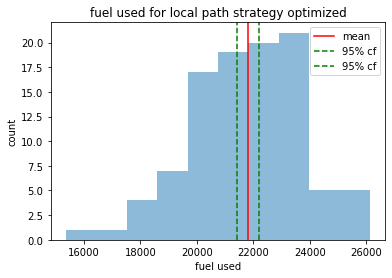

In [219]:
#plot results 
cf1 = st.t.interval(0.95, len([i[0] for i in f1op11opt])-1, loc=np.mean([i[0] for i in f1op11opt]), scale=st.sem([i[0] for i in f1op11opt]))
plt.title('fuel used for local path strategy optimized')
plt.xlabel('fuel used')
plt.ylabel('count')
plt.hist([i[0] for i in f1op11opt], alpha = 0.5)
plt.axvline(np.mean([i[0] for i in f1op11opt]), color = 'r', label = 'mean', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf', linestyle = '--')
plt.legend()


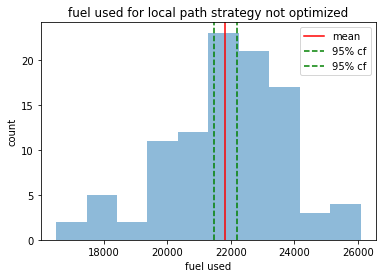

In [220]:
#plot results
cf2 = st.t.interval(0.95, len([i[0] for i in f1op11nopt])-1, loc=np.mean([i[0] for i in f1op11nopt]), scale=st.sem([i[0] for i in f1op11nopt]))
plt.title('fuel used for local path strategy not optimized')
plt.xlabel('fuel used')
plt.ylabel('count')
plt.hist([i[0] for i in f1op11nopt], alpha = 0.5)
#plt.hist(y, alpha = 0.5)
plt.axvline(np.mean([i[0] for i in f1op11nopt]), color = 'r', label = 'mean', linestyle = '-')
plt.axvline(cf2[0], color = 'g', label = '95% cf', linestyle = '--')
plt.axvline(cf2[1], color = 'g', label = '95% cf', linestyle = '--')
plt.legend()

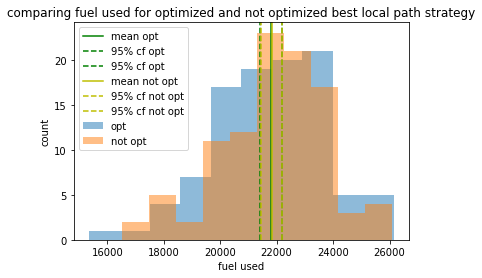

In [226]:
#plot results
cf1 = st.t.interval(0.95, len([i[0] for i in f1op11opt])-1, loc=np.mean([i[0] for i in f1op11opt]), scale=st.sem([i[0] for i in f1op11opt]))
cf2 = st.t.interval(0.95, len([i[0] for i in f1op11nopt])-1, loc=np.mean([i[0] for i in f1op11nopt]), scale=st.sem([i[0] for i in f1op11nopt]))
plt.title('comparing fuel used for optimized and not optimized best local path strategy')
plt.xlabel('fuel used')
plt.ylabel('count')
plt.hist([i[0] for i in f1op11opt], alpha = 0.5, label = 'opt')
plt.axvline(np.mean([i[0] for i in f1op11opt]), color = 'g', label = 'mean opt', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf opt', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf opt', linestyle = '--')


plt.hist([i[0] for i in f1op11nopt], alpha = 0.5, label = 'not opt')
plt.axvline(np.mean([i[0] for i in f1op11nopt]), color = 'y', label = 'mean not opt', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.legend()

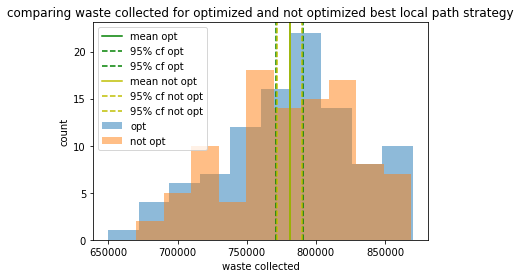

In [227]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] for i in f1op11opt])-1, loc=np.mean([i[1] for i in f1op11opt]), scale=st.sem([i[1] for i in f1op11opt]))
cf2 = st.t.interval(0.95, len([i[1] for i in f1op11nopt])-1, loc=np.mean([i[1] for i in f1op11nopt]), scale=st.sem([i[1] for i in f1op11nopt]))
plt.title('comparing waste collected for optimized and not optimized best local path strategy')
plt.xlabel('waste collected')
plt.ylabel('count')
plt.hist([i[1] for i in f1op11opt], alpha = 0.5, label = 'opt')
plt.axvline(np.mean([i[1] for i in f1op11opt]), color = 'g', label = 'mean opt', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf opt', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf opt', linestyle = '--')


plt.hist([i[1] for i in f1op11nopt], alpha = 0.5, label = 'not opt')
plt.axvline(np.mean([i[1] for i in f1op11nopt]), color = 'y', label = 'mean not opt', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.legend()

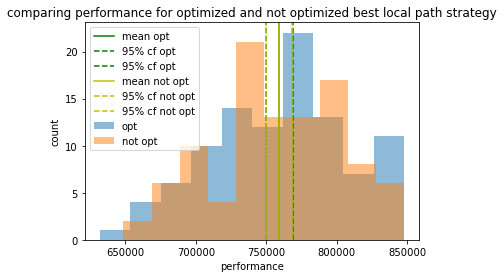

In [228]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] - i[0] for i in f1op11opt])-1, loc=np.mean([i[1]- i[0]  for i in f1op11opt]), scale=st.sem([i[1]- i[0]  for i in f1op11opt]))
cf2 = st.t.interval(0.95, len([i[1]- i[0]  for i in f1op11nopt])-1, loc=np.mean([i[1]- i[0]  for i in f1op11nopt]), scale=st.sem([i[1]- i[0]  for i in f1op11nopt]))
plt.title('comparing performance for optimized and not optimized best local path strategy')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1]- i[0]  for i in f1op11opt], alpha = 0.5, label = 'opt')
plt.axvline(np.mean([i[1]- i[0]  for i in f1op11opt]), color = 'g', label = 'mean opt', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf opt', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf opt', linestyle = '--')


plt.hist([i[1]- i[0]  for i in f1op11nopt], alpha = 0.5, label = 'not opt')
plt.axvline(np.mean([i[1]- i[0]  for i in f1op11nopt]), color = 'y', label = 'mean not opt', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf not opt', linestyle = '--')
plt.legend()

In [ ]:
#define lists to store results
f1op110 = []
f1op11inf = []

#repeat simulation 100 times
for i in range(100):
    
    #set up network
    farmnet, station, wastesites = create_farm_network(100, 0.1, 100, 1000, 0.1, 3)
    
    #define trucks and truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype =0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype =0, move = 0)

    truck_list = [truck1, truck2, truck3]
    
    #do simulation and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    f1op110.append(a)
    
    #reset waset at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        
    #define trucks and truck list
    truck1 = truck(station, 10000,  800, 80, 0, ftype =2)
    truck2 = truck(station, 10000,  800, 80, 0, ftype =2)
    truck3 = truck(station, 10000,  800, 80, 0, ftype =2)

    truck_list = [truck1, truck2, truck3]
    
    #do simulation and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites, optimize = False)
    f1op11inf.append(a)

In [203]:
#print results
print(np.mean([i[0] for i in f1op110]))
print(np.mean([i[0] for i in f1op11inf]))
print()
print(np.mean([i[1] for i in f1op110]))
print(np.mean([i[1] for i in f1op11inf]))



print()
print('third')
print()

print(np.mean([i[1] - i[0] for i in f1op110]))
print(np.mean([i[1] - i[0] for i in f1op11inf]))


21080.860142532405
24537.65686406905

771979.6024628293
614648.2269632062

third

750898.7423202969
590110.5700991374


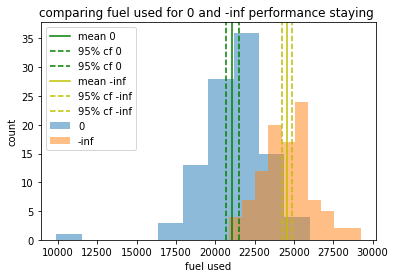

In [229]:
#plot results
cf1 = st.t.interval(0.95, len([i[0] for i in f1op110])-1, loc=np.mean([i[0] for i in f1op110]), scale=st.sem([i[0] for i in f1op110]))
cf2 = st.t.interval(0.95, len([i[0] for i in f1op11inf])-1, loc=np.mean([i[0] for i in f1op11inf]), scale=st.sem([i[0] for i in f1op11inf]))
plt.title('comparing fuel used for 0 and -inf performance staying ')
plt.xlabel('fuel used')
plt.ylabel('count')
plt.hist([i[0] for i in f1op110], alpha = 0.5, label = '0')
plt.axvline(np.mean([i[0] for i in f1op110]), color = 'g', label = 'mean 0', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf 0', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf 0', linestyle = '--')


plt.hist([i[0] for i in f1op11inf], alpha = 0.5, label = '-inf')
plt.axvline(np.mean([i[0] for i in f1op11inf]), color = 'y', label = 'mean -inf', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.legend()

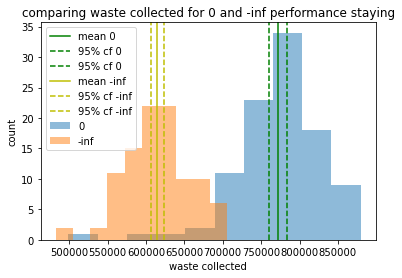

In [230]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] for i in f1op110])-1, loc=np.mean([i[1] for i in f1op110]), scale=st.sem([i[1] for i in f1op110]))
cf2 = st.t.interval(0.95, len([i[1] for i in f1op11inf])-1, loc=np.mean([i[1] for i in f1op11inf]), scale=st.sem([i[1] for i in f1op11inf]))
plt.title('comparing waste collected for 0 and -inf performance staying')
plt.xlabel('waste collected')
plt.ylabel('count')
plt.hist([i[1] for i in f1op110], alpha = 0.5, label = '0')
plt.axvline(np.mean([i[1] for i in f1op110]), color = 'g', label = 'mean 0', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf 0', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf 0', linestyle = '--')


plt.hist([i[1] for i in f1op11inf], alpha = 0.5, label = '-inf')
plt.axvline(np.mean([i[1] for i in f1op11inf]), color = 'y', label = 'mean -inf', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.legend()

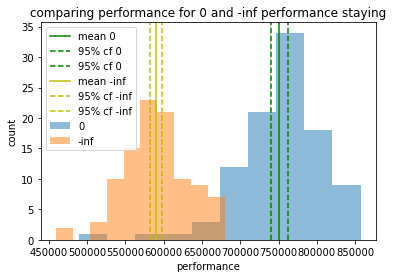

In [291]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] - i[0] for i in f1op110])-1, loc=np.mean([i[1]- i[0]  for i in f1op110]), scale=st.sem([i[1]- i[0]  for i in f1op110]))
cf2 = st.t.interval(0.95, len([i[1]- i[0]  for i in f1op11inf])-1, loc=np.mean([i[1]- i[0]  for i in f1op11inf]), scale=st.sem([i[1]- i[0]  for i in f1op11inf]))
plt.title('comparing performance for 0 and -inf performance staying')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1]- i[0]  for i in f1op110], alpha = 0.5, label = '0')
plt.axvline(np.mean([i[1]- i[0]  for i in f1op110]), color = 'g', label = 'mean 0', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf 0', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf 0', linestyle = '--')


plt.hist([i[1]- i[0]  for i in f1op11inf], alpha = 0.5, label = '-inf')
plt.axvline(np.mean([i[1]- i[0]  for i in f1op11inf]), color = 'y', label = 'mean -inf', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf -inf', linestyle = '--')
plt.legend()

In [ ]:
#define lists to store results
op0 = []
op21 = []
op22 = []
op23 = []
op1 = []

#repeat simulation 50 times
for i in range(50):
    
    #set up network
    farmnet, station, wastesites = create_farm_network(100, 0.1, 100, 1000, 0.1, 3)
    
    #create trucks and store in truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 2)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 2)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 2)

    truck_list = [truck1, truck2, truck3]

    #run simulation and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op0.append(a)
    
    #reset waste at nodes 
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        
        
    #create trucks and store in truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 1)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 1)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 1)

    truck_list = [truck1, truck2, truck3]
    
    #run simulation and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op1.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        
        
    #create trucks and store in truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1, truck2, truck3]
    
    #run simulation and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op21.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        
        
    #create trucks and store in truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1, truck2, truck3]

    #run simulation and store results
    a = simulation(farmnet, truck_list, 500, 2, station, wastesites)
    op22.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        
    #create trucks and store in truck list
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1, truck2, truck3]

    #run simulation and store results
    a = simulation(farmnet, truck_list, 500, 3, station, wastesites)
    op23.append(a)
    
        


In [247]:
#print results
print(np.mean([i[0]  for i in op0]))
print(np.mean([i[0] for i in op1]))
print(np.mean([i[0]  for i in op21]))
print(np.mean([i[0]  for i in op22]))
print(np.mean([i[0]  for i in op23]))




24804.925847292026
11690.252554331484
21850.47885842671
21792.165921470845
21426.106751233256


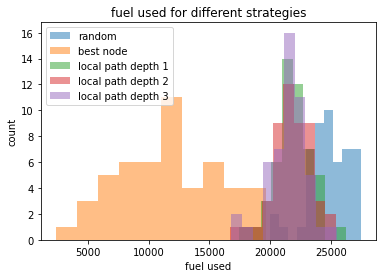

In [248]:
#plot results
plt.title('fuel used for different strategies')
plt.xlabel('fuel used')
plt.ylabel('count')
plt.hist([i[0] for i in op0], alpha = 0.5, label = 'random')
plt.hist([i[0] for i in op1], alpha = 0.5, label = 'best node')
plt.hist([i[0] for i in op21], alpha = 0.5, label = 'local path depth 1')
plt.hist([i[0] for i in op22], alpha = 0.5, label = 'local path depth 2')
plt.hist([i[0] for i in op23], alpha = 0.5, label = 'local path depth 3')

plt.legend()

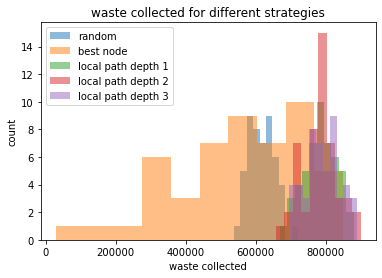

In [249]:
#plot results
plt.title('waste collected for different strategies')
plt.xlabel('waste collected')
plt.ylabel('count')
plt.hist([i[1] for i in op0], alpha = 0.5, label = 'random')
plt.hist([i[1] for i in op1], alpha = 0.5, label = 'best node')
plt.hist([i[1] for i in op21], alpha = 0.5, label = 'local path depth 1')
plt.hist([i[1] for i in op22], alpha = 0.5, label = 'local path depth 2')
plt.hist([i[1] for i in op23], alpha = 0.5, label = 'local path depth 3')

plt.legend()

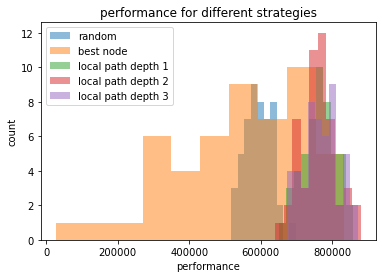

In [250]:
#plot results
plt.title('performance for different strategies')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1] - i[0] for i in op0], alpha = 0.5, label = 'random')
plt.hist([i[1] -i[0] for i in op1], alpha = 0.5, label = 'best node')
plt.hist([i[1] -i[0] for i in op21], alpha = 0.5, label = 'local path depth 1')
plt.hist([i[1] -i[0] for i in op22], alpha = 0.5, label = 'local path depth 2')
plt.hist([i[1] -i[0] for i in op23], alpha = 0.5, label = 'local path depth 3')
plt.legend()

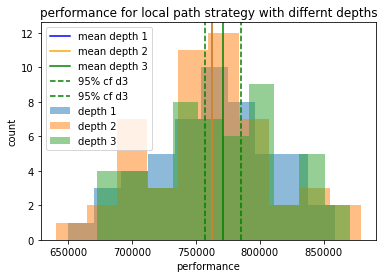

In [266]:
#plot results
cf = st.t.interval(0.95, len([i[1] - i[0] for i in op23])-1, loc=np.mean([i[1] - i[0] for i in op23]), scale=st.sem([i[1] - i[0] for i in op23]))
plt.title('performance for local path strategy with differnt depths')
plt.xlabel('performance')
plt.ylabel('count')

plt.hist([i[1] -i[0] for i in op21], alpha = 0.5, label = 'depth 1')
plt.hist([i[1] -i[0] for i in op22], alpha = 0.5, label = 'depth 2')
plt.hist([i[1] -i[0] for i in op23], alpha = 0.5, label = 'depth 3')

plt.axvline(np.mean([i[1] - i[0] for i in op21]), color = 'blue', label = 'mean depth 1', linestyle = '-')
plt.axvline(np.mean([i[1] - i[0] for i in op22]), color = 'orange', label = 'mean depth 2', linestyle = '-')
plt.axvline(np.mean([i[1] - i[0] for i in op23]), color = 'green', label = 'mean depth 3', linestyle = '-')
plt.axvline(cf[0], color = 'g', label = '95% cf d3', linestyle = '--')
plt.axvline(cf[1], color = 'g', label = '95% cf d3', linestyle = '--')
plt.legend()

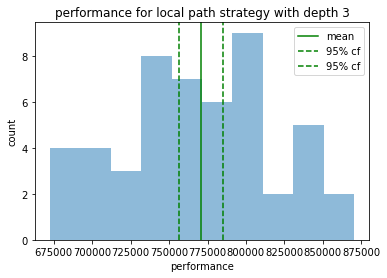

In [267]:
#plot results
cf = st.t.interval(0.95, len([i[1] - i[0] for i in op23])-1, loc=np.mean([i[1] - i[0] for i in op23]), scale=st.sem([i[1] - i[0] for i in op23]))
plt.title('performance for local path strategy with depth 3')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1] -i[0] for i in op23], alpha = 0.5)
plt.axvline(np.mean([i[1] - i[0] for i in op23]), color = 'green', label = 'mean', linestyle = '-')
plt.axvline(cf[0], color = 'g', label = '95% cf', linestyle = '--')
plt.axvline(cf[1], color = 'g', label = '95% cf', linestyle = '--')
plt.legend()

In [ ]:
#define lists to store results
op01 = []
op211 = []

op02 = []
op212 = []

op03 = []
op213 = []


#repeat simulatin 50 times
for i in range(50):
    
    #set up network
    farmnet, station, wastesites = create_farm_network(100, 0.3, 100, 1000, 0.1, 3)

    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 2)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 2)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 2)

    truck_list = [truck1, truck2, truck3]

    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op01.append(a)
    
    #reset waste at nodes 
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        
    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1, truck2, truck3]

    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op211.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        

    #set up network
    farmnet, station, wastesites = create_farm_network(150, 0.1, 100, 1000, 0.1, 3)

    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 2)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 2)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 2)

    truck_list = [truck1, truck2, truck3]

    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op02.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        
        
        
    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1, truck2, truck3]

    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op212.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        
        
    
    #set up network
    farmnet, station, wastesites = create_farm_network(100, 0.1, 100, 1000, 0.1, 3)

    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 2)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 2)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 2)

    truck_list = [truck1]

    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op03.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0
        

        
    #create trucks and define truck list 
    truck1 = truck(station, 10000,  800, 80, 1, ftype = 0, move = 0)
    truck2 = truck(station, 10000,  800, 80, 2, ftype = 0, move = 0)
    truck3 = truck(station, 10000,  800, 80, 3, ftype = 0, move = 0)

    truck_list = [truck1]
    
    #run simulatoin and store results
    a = simulation(farmnet, truck_list, 500, 1, station, wastesites)
    op213.append(a)
    
    #reset waste at nodes
    for i in farmnet.nodes:
        farmnet.nodes[i]['waste'] = 0 
        

    
        
        
    

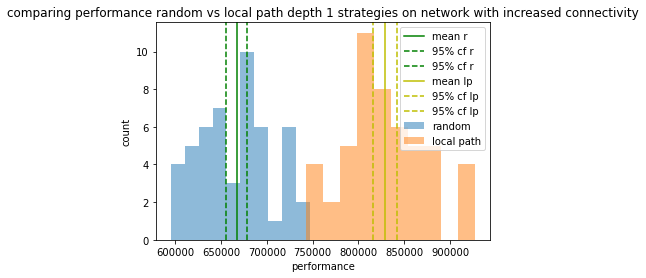

In [286]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] - i[0] for i in op01])-1, loc=np.mean([i[1]- i[0]  for i in op01]), scale=st.sem([i[1]- i[0]  for i in op01]))
cf2 = st.t.interval(0.95, len([i[1]- i[0]  for i in op211])-1, loc=np.mean([i[1]- i[0]  for i in op211]), scale=st.sem([i[1]- i[0]  for i in op211]))
plt.title('comparing performance random vs local path depth 1 strategies on network with increased connectivity')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1]- i[0]  for i in op01], alpha = 0.5, label = 'random')
plt.axvline(np.mean([i[1]- i[0]  for i in op01]), color = 'g', label = 'mean r', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf r', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf r', linestyle = '--')


plt.hist([i[1]- i[0]  for i in op211], alpha = 0.5, label = 'local path')
plt.axvline(np.mean([i[1]- i[0]  for i in op211]), color = 'y', label = 'mean lp', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf lp', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf lp', linestyle = '--')
plt.legend()

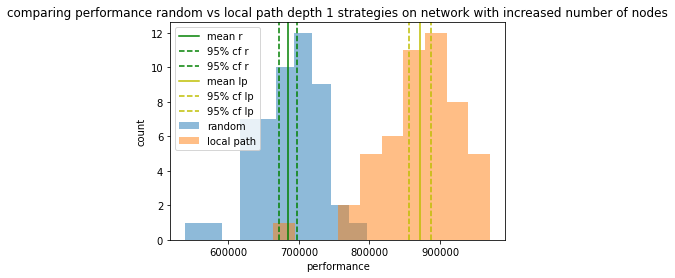

In [289]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] - i[0] for i in op02])-1, loc=np.mean([i[1]- i[0]  for i in op02]), scale=st.sem([i[1]- i[0]  for i in op02]))
cf2 = st.t.interval(0.95, len([i[1]- i[0]  for i in op212])-1, loc=np.mean([i[1]- i[0]  for i in op212]), scale=st.sem([i[1]- i[0]  for i in op212]))
plt.title('comparing performance random vs local path depth 1 strategies on network with increased number of nodes')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1]- i[0]  for i in op02], alpha = 0.5, label = 'random')
plt.axvline(np.mean([i[1]- i[0]  for i in op02]), color = 'g', label = 'mean r', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf r', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf r', linestyle = '--')


plt.hist([i[1]- i[0]  for i in op212], alpha = 0.5, label = 'local path')
plt.axvline(np.mean([i[1]- i[0]  for i in op212]), color = 'y', label = 'mean lp', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf lp', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf lp', linestyle = '--')
plt.legend()

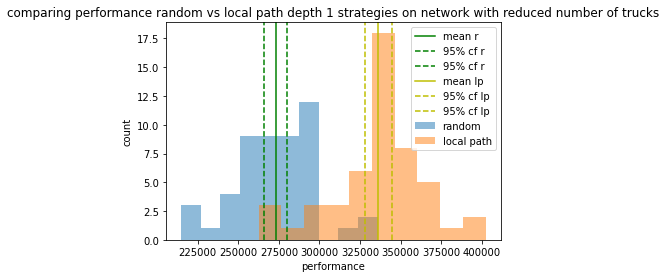

In [290]:
#plot results
cf1 = st.t.interval(0.95, len([i[1] - i[0] for i in op03])-1, loc=np.mean([i[1]- i[0]  for i in op03]), scale=st.sem([i[1]- i[0]  for i in op03]))
cf2 = st.t.interval(0.95, len([i[1]- i[0]  for i in op213])-1, loc=np.mean([i[1]- i[0]  for i in op213]), scale=st.sem([i[1]- i[0]  for i in op213]))
plt.title('comparing performance random vs local path depth 1 strategies on network with reduced number of trucks')
plt.xlabel('performance')
plt.ylabel('count')
plt.hist([i[1]- i[0]  for i in op03], alpha = 0.5, label = 'random')
plt.axvline(np.mean([i[1]- i[0]  for i in op03]), color = 'g', label = 'mean r', linestyle = '-')
plt.axvline(cf1[0], color = 'g', label = '95% cf r', linestyle = '--')
plt.axvline(cf1[1], color = 'g', label = '95% cf r', linestyle = '--')


plt.hist([i[1]- i[0]  for i in op213], alpha = 0.5, label = 'local path')
plt.axvline(np.mean([i[1]- i[0]  for i in op213]), color = 'y', label = 'mean lp', linestyle = '-')
plt.axvline(cf2[0], color = 'y', label = '95% cf lp', linestyle = '--')
plt.axvline(cf2[1], color = 'y', label = '95% cf lp', linestyle = '--')
plt.legend()